In [2]:
%load_ext autoreload
%autoreload 2
from DarkMatter import *
from scipy.interpolate import interp1d

Welcome to JupyROOT 6.23/01


## Step 1: Generate fake PSF (e.g., 10 TeV)

In [2]:
dwarf = "ursa_minor"
en = 10000

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
PSF = irf.PSF

In [3]:
gPSF1D = JProfile.getPSF1D(PSF, en, package="VEGAS")
vts = JProfile.getPSFcont(gPSF1D)
int_vts = interp1d(vts[1], vts[0])
angres_vts = int_vts(0.6827)

gPSF1D_fake = ResponseFunction.fakePSF(0.02)
fake = JProfile.getPSFcont(gPSF1D_fake)
int_fake = interp1d(fake[1], fake[0])
angres_fake = int_fake(0.6827)

(0.0, 0.5)

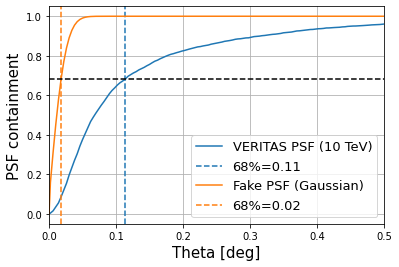

In [4]:
etc = plt.plot(*vts, label="VERITAS PSF ({:.0f} TeV)".format(en/1000))
plt.axvline(angres_vts, color=etc[0].get_color(), ls="--", label="68%={:.2f}".format(angres_vts))

etc = plt.plot(*fake, label="Fake PSF (Gaussian)")
plt.axvline(angres_fake, color=etc[0].get_color(), ls="--", label="68%={:.2f}".format(angres_fake))

plt.axhline(0.68, color="k", ls="--")
plt.xlabel("Theta [deg]", fontsize=15)
plt.ylabel("PSF containment", fontsize=15)
plt.legend(fontsize=13)
plt.grid()
plt.xlim(0, 0.5)

## Step 2: Convolve with a J profile

In [5]:
gJProf = JProfile.calcJProfile(dwarf, seed=defaultNum[dwarf])

In [6]:
J_vts, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D, package="VEGAS")
J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
jProfile_fake = interp1d([10, 1e8], [J_fake, J_fake])

print("Convolved J profile")
print("VERITAS: {:.3e}".format(J_vts))
print("Fake: {:.3e}".format(J_fake))
print("Ratio: {:.2f}".format(J_fake/J_vts))

Convolved J profile
VERITAS: 4.530e+18
Fake: 5.628e+18
Ratio: 1.24


In [7]:
jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS",  seed=defaultNum[dwarf], return_array=True, save_root=False)

  0%|          | 0/36 [00:00<?, ?it/s]

In [8]:
fake_j = []
theta = [0.2, 0.15,  0.1, 0.08, 0.05, ]
for th in theta :
    gPSF1D_fake = ResponseFunction.fakePSF(th)
    J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
    fake_j.append(J_fake)

Text(0, 0.5, 'Convolved J profile [GeV$^2$cm$^{-5}$]')

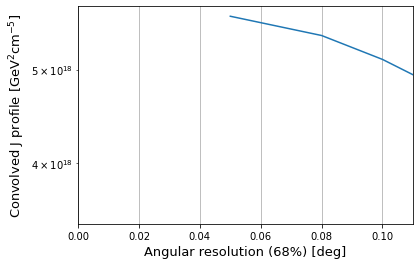

In [9]:
plt.plot(theta, fake_j)
plt.grid()
plt.yscale("log")
plt.xlim(0, 0.11)
plt.xlabel("Angular resolution (68%) [deg]", fontsize=13)
plt.ylabel(r"Convolved J profile [GeV$^2$cm$^{-5}$]", fontsize=13)

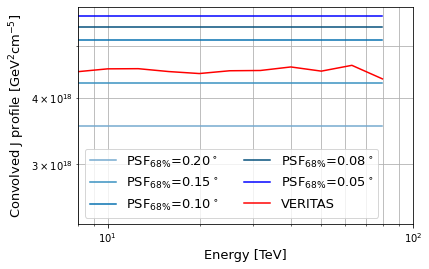

In [10]:
c = ["#74a9cf", "#3690c0", "#0570b0",  "#034e7b", "blue"]
for i, p in enumerate(theta):
    plt.plot(jProfile_vts[0][:,0]/1e3, np.ones(len(jProfile_vts[0][:,0]))*fake_j[i], color=c[i], label="PSF$_{{68\%}}$={:.2f}$^\circ$".format(p))
    
plt.plot(jProfile_vts[0][:,0]/1e3, jProfile_vts[0][:,1], label="VERITAS", color="r")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy [TeV]", fontsize=13)
plt.ylabel(r"Convolved J profile [GeV$^2$cm$^{-5}$]", fontsize=13)
plt.legend(fontsize=13, ncol=2, loc=3)
#plt.ylim(1e18, 5e18)
plt.xlim(8, 100)
plt.grid(which="both")

## Step 3: Generate EA and Bias

(2000, 872510.4278850302)

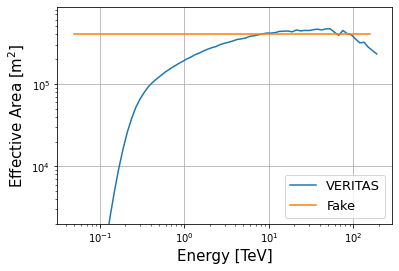

In [11]:
newirf = ResponseFunction.newirf("VEGAS")
newirf.EA = ResponseFunction.fakeEA(4e5, benchmark="VEGAS")
x, EA_vts = getArray(irf.EA)
x2, EA_fake = getArray(newirf.EA)
plt.plot(10**x, EA_vts, label="VERITAS")
plt.plot(10**x2, EA_fake, label="Fake")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(fontsize=13)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel(r"Effective Area [m$^2$]", fontsize=15)
plt.ylim(2000,)

(<cppyy.gbl.TCanvas object at 0x7fed2a287810>,
 <cppyy.gbl.TH2D object at 0x7fed490c8000>)

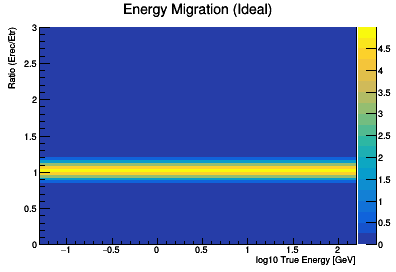

In [12]:
newirf.Bias = ResponseFunction.fakeBias(0.08, benchmark="VEGAS")
newirf.Bias.SetTitle("Energy Migration (Ideal)")
plotRoot(newirf.Bias)

## Step 4: Get a signal distribution

In [13]:
newirf.exposure = irf.exposure

(<cppyy.gbl.TCanvas object at 0x7fed2ba7fa40>,
 <cppyy.gbl.TH1D object at 0x7fed2ba7a600>)

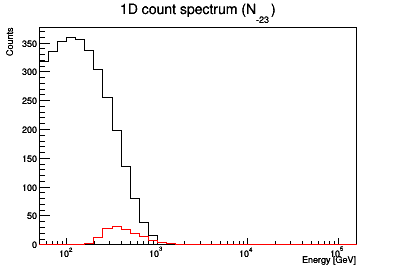

In [14]:
# 1 TeV
sig_fake = Likelihood.calcSignal(dwarf, 1000, newirf, jArray=True,  jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 1000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

(<cppyy.gbl.TCanvas object at 0x7fed2a080ed0>,
 <cppyy.gbl.TH1D object at 0x7fed2a25ec40>)

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


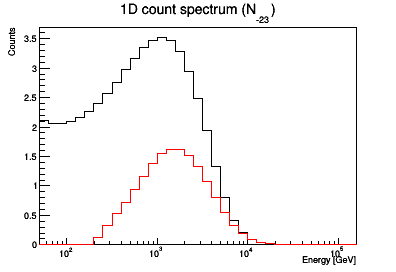

In [15]:
# 10 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 10000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 10000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

(<cppyy.gbl.TCanvas object at 0x7fed498850d0>,
 <cppyy.gbl.TH1D object at 0x7fed2c92b1f0>)

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


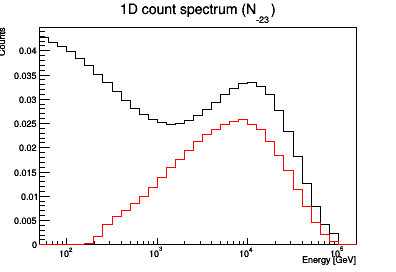

In [16]:
# 100 TeV
sig_fake = Likelihood.calcSignal(dwarf, 100000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 100000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

### Step 4-1: Add cutoff in EA

In [17]:
newirf.EA = ResponseFunction.fakeEA(4e5, low_cutoff=0.55, s=1.1, benchmark="VEGAS")

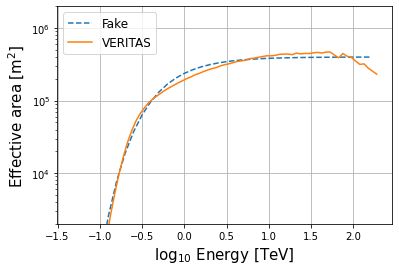

In [18]:
plt.plot(*getArray(newirf.EA), label="Fake", ls="--")
plt.plot(*getArray(irf.EA), label="VERITAS")

plt.yscale("log")
plt.ylim(2000, 2e6)
plt.xlabel("log$_{10}$ Energy [TeV]", fontsize=15)
plt.ylabel("Effective area [m$^2$]", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

Total counts:  15.936531524058921 22.57856321299406


(<cppyy.gbl.TCanvas object at 0x7fed498e4730>,
 <cppyy.gbl.TH1D object at 0x7fed2a05a2d0>)

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


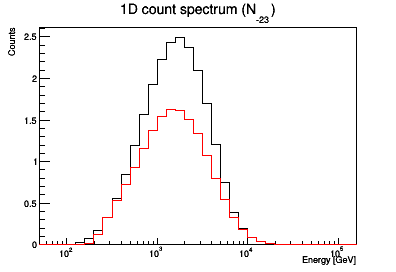

In [19]:
# 10 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 10000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 10000, irf, jArray=True, jProfile=jProfile_vts)
print("Total counts: ", sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]))
plotRoot(sig_fake, sig_vts, logx=True)

Total counts:  0.390171816685786 0.48772847135065855


(<cppyy.gbl.TCanvas object at 0x7fed498b0d30>,
 <cppyy.gbl.TH1D object at 0x7fed2a0d0120>)

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


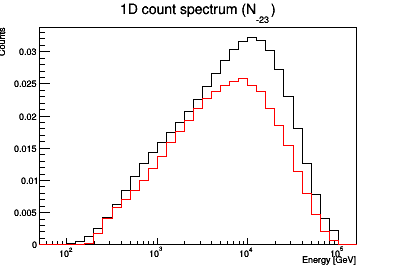

In [20]:
# 100 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 100000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 100000, irf, jArray=True, jProfile=jProfile_vts)
print("Total counts: ", sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]))
plotRoot(sig_fake, sig_vts, logx=True)

## Step 5: Compare counts at VHE and UHE

In [21]:
E = np.logspace(2.5, 6, 10)
cnts = []
for en in tqdm(E):
    sig_fake = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake)
    sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts)
    sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM")
    sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts, DM_spectra="HDM")
    cnts.append([sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]), sum(getArray(sig_vts_hdm)[1]), sum(getArray(sig_fake_hdm)[1])])
cnts = np.asarray(cnts)

  0%|          | 0/10 [00:00<?, ?it/s]

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


<ipython-input-22-e3fb324a475c>:13: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(E/1e3, cnts[:,0]/cnts[:,1], color=etc[0].get_color(), label="PPPC")
<ipython-input-22-e3fb324a475c>:14: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(E/1e3, cnts[:,2]/cnts[:,3], color=etc2[0].get_color(), label="HDM")
<ipython-input-22-e3fb324a475c>:22: RuntimeWarning: divide by zero encountered in true_divide
  ax[2].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
<ipython-input-22-e3fb324a475c>:23: RuntimeWarning: divide by zero encountered in true_divide
  ax[2].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="Fake")


(0.2, 2000.0)

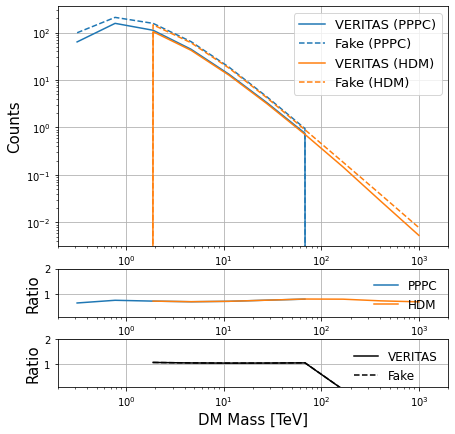

In [22]:
f, ax = plt.subplots(3,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1,1]})
etc = ax[0].plot(E/1e3, cnts[:,0], label="VERITAS (PPPC)")
ax[0].plot(E/1e3, cnts[:,1], label="Fake (PPPC)", color=etc[0].get_color(), ls="--")
etc2 = ax[0].plot(E/1e3, cnts[:,2], label="VERITAS (HDM)")
ax[0].plot(E/1e3, cnts[:,3], label="Fake (HDM)", color=etc2[0].get_color(), ls="--")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].grid()
ax[0].set_ylabel("Counts", fontsize=15)
ax[0].legend(fontsize=13)
ax[0].set_xlim(0.2, 2e3)

ax[1].plot(E/1e3, cnts[:,0]/cnts[:,1], color=etc[0].get_color(), label="PPPC")
ax[1].plot(E/1e3, cnts[:,2]/cnts[:,3], color=etc2[0].get_color(), label="HDM")
ax[1].set_xscale("log")
ax[1].set_ylim(0.1, 2)
ax[1].grid()
ax[1].set_ylabel("Ratio", fontsize=15)
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlim(0.2, 2e3)

ax[2].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
ax[2].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="Fake")
ax[2].set_xscale("log")
ax[2].set_xlabel("DM Mass [TeV]", fontsize=15)
ax[2].set_ylim(0.1, 2)
ax[2].grid()
ax[2].set_ylabel("Ratio", fontsize=15)
ax[2].legend(fontsize=12, frameon=False)
ax[2].set_xlim(0.2, 2e3)

### Step 5.1: with CTA effective area

In [29]:
EA = [[39.432182, 1.3815514],
[44.520336, 8.865806],
[83.476776, 72.7264],
[141.71916, 300.02066],
[282.70816, 1516.2206],
[421.37457, 3409.6685],
[715.7195, 8153.1963],
[1234.7367, 15931.808],
[2265.9258, 22543.19],
[3457.7178, 30600.43],
[6906.092, 39160.16],
[14671.542, 40145.27],
[28859.38, 45507.008],
[44389.46, 46558.973],
[68290.3, 38144.926]]


In [30]:
EA = np.asarray(EA)

In [31]:
EA[:,0] = np.log10(EA[:,0])

In [32]:
EA[:,0] = EA[:,0]-3

In [33]:
np.save("HAWC_EA", EA)

In [43]:
CTA_N = np.load("./temp/CTA_North_50h_EA.npy")

HAWC = np.load("./temp/HAWC_EA.npy")

irf = ResponseFunction.VEGAS.readIRFs("segue_1")
#newirf.EA = ResponseFunction.fakeEA(1e6, benchmark="VEGAS", low_cutoff=0.4, s=1.2)

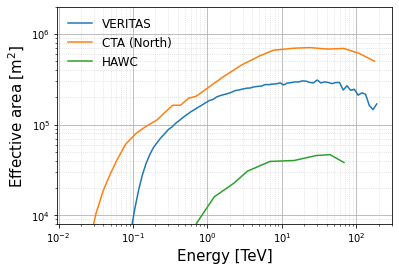

In [57]:
x, y = getArray(irf.EA)

plt.plot(10**x, y, label="VERITAS")
plt.plot(10**CTA_N[:,0], CTA_N[:,1], label="CTA (North)")
#plt.plot(10**CTA_S[:,0], CTA_S[:,1], label="CTA South", ls="--", alpha=0.5)
plt.plot(10**HAWC[:,0], HAWC[:,1], label="HAWC")
#plt.plot(LHAASO[:,0], LHAASO[:,1], label="LHAASO", ls="--", alpha=0.5)

plt.xscale("log")
plt.yscale("log")
plt.ylim(8e3, 2e6)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Effective area [m$^2$]", fontsize=15)
plt.grid(which="minor", ls=":", alpha=0.5)
plt.grid(which="major")
plt.legend(fontsize=12, ncol=1, loc=2, frameon=False)
plt.savefig("EA.pdf")

In [25]:
E = np.logspace(2.5, 6, 10)
cnts = []
jProfile = JProfile.generateConvolvedJ(dwarf, package="VEGAS", seed=defaultNum[dwarf], return_array=True, save_root=False)
for en in tqdm(E):
    sig_fake = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, channel="bbar")
    sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="bbar")
    sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM", channel="bbar")
    sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="bbar")
    cnts.append([sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]), sum(getArray(sig_vts_hdm)[1]), sum(getArray(sig_fake_hdm)[1])])
cnts = np.asarray(cnts)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-26-9c46dcf22935>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
<ipython-input-26-9c46dcf22935>:14: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="CTA")


(0.2, 2000.0)

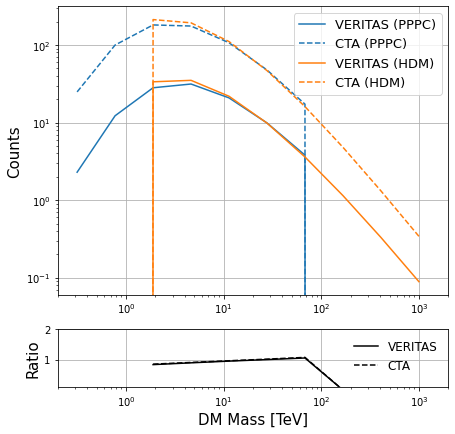

In [26]:
f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})
etc = ax[0].plot(E/1e3, cnts[:,0], label="VERITAS (PPPC)")
ax[0].plot(E/1e3, cnts[:,1], label="CTA (PPPC)", color=etc[0].get_color(), ls="--")
etc2 = ax[0].plot(E/1e3, cnts[:,2], label="VERITAS (HDM)")
ax[0].plot(E/1e3, cnts[:,3], label="CTA (HDM)", color=etc2[0].get_color(), ls="--")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].grid()
ax[0].set_ylabel("Counts", fontsize=15)
ax[0].legend(fontsize=13)
ax[0].set_xlim(0.2, 2e3)

ax[1].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
ax[1].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="CTA")
ax[1].set_xscale("log")
ax[1].set_xlabel("DM Mass [TeV]", fontsize=15)
ax[1].set_ylim(0.1, 2)
ax[1].grid()
ax[1].set_ylabel("Ratio", fontsize=15)
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlim(0.2, 2e3)

## Step 7: Test other channels

In [27]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ"]
dwarf="ursa_minor"
jProfile = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)

[Warning] IRFs and package are mismatched. The package name is changed from EventDisplay to VEGAS.


  0%|          | 0/36 [00:00<?, ?it/s]

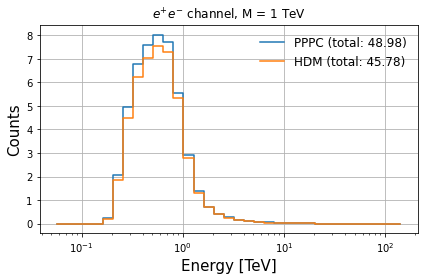

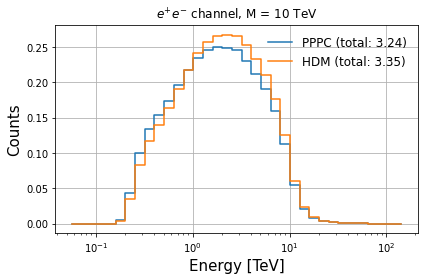

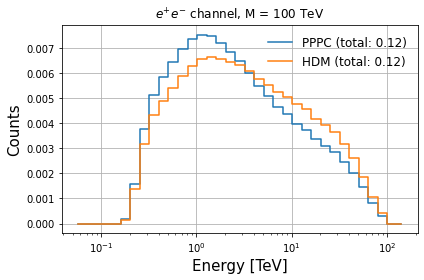

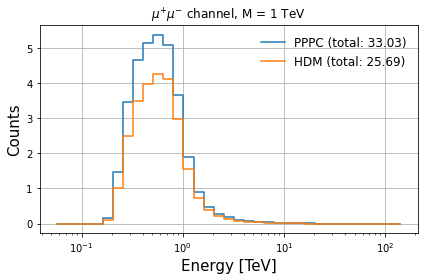

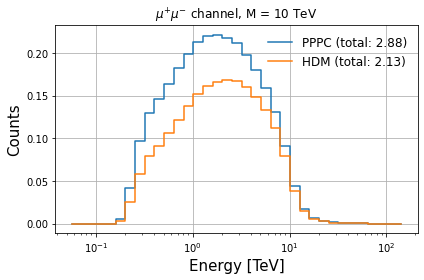

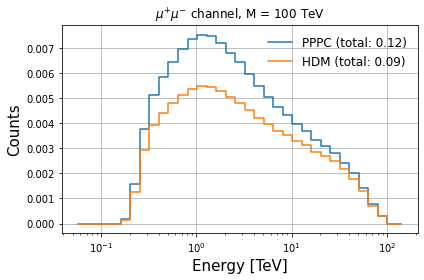

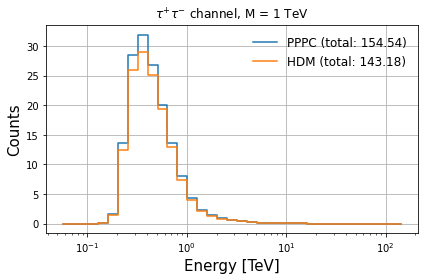

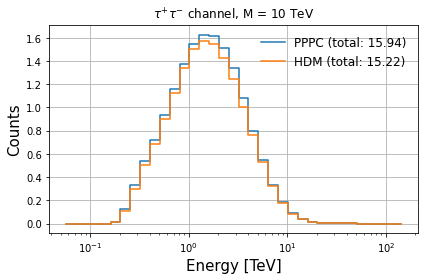

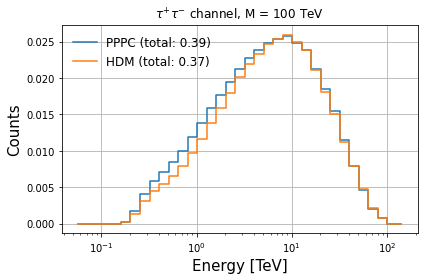

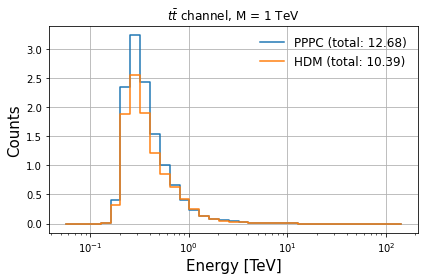

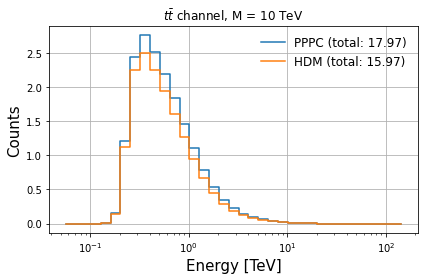

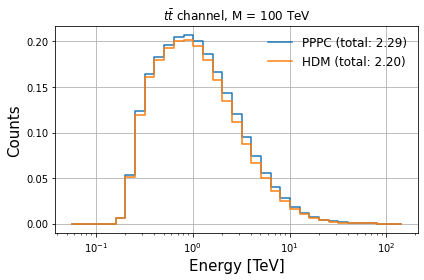

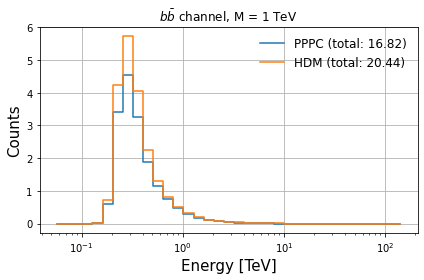

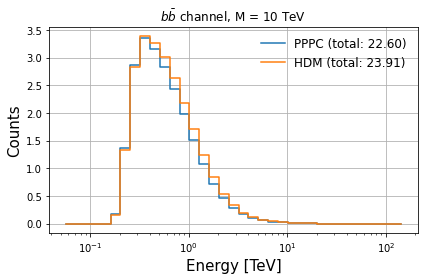

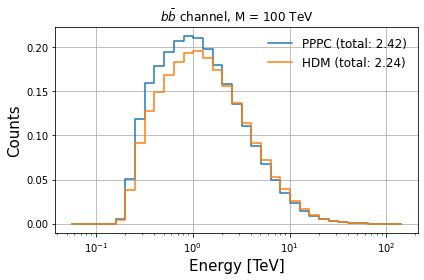

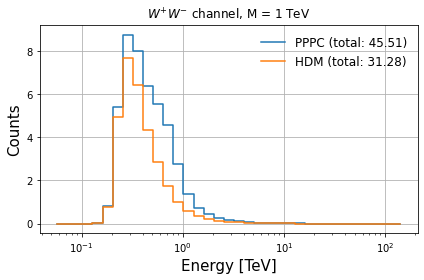

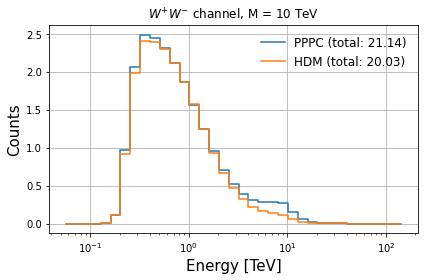

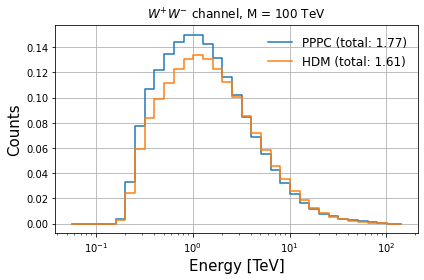

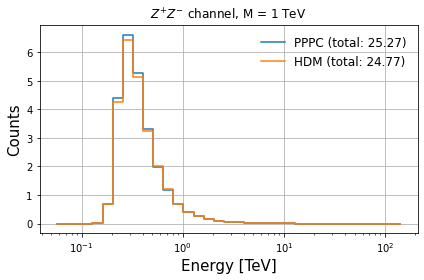

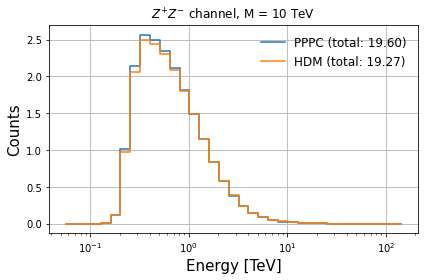

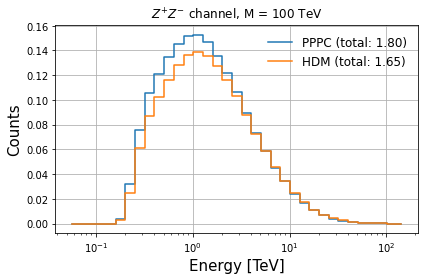

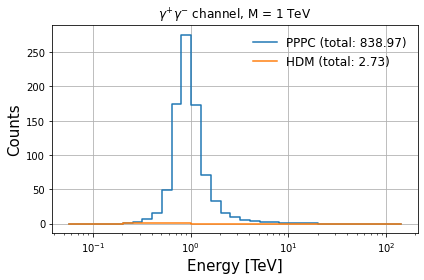

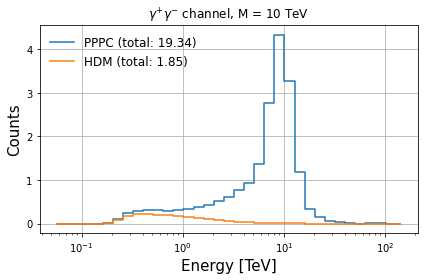

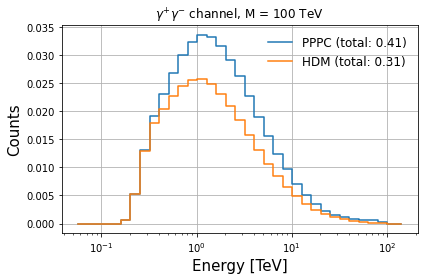

In [28]:
E = [1000, 10000, 100000]
cnts = {}

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$"]
for c, cl in zip(chan, chan_lab):
    for en in E:
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        x1, y1 = getArray(sig_vts)
        x2, y2 = getArray(sig_vts_hdm)
        plt.step(x1/1e3, y1, label="PPPC (total: {:.2f})".format(sum(y1)), where="mid")
        plt.step(x2/1e3, y2, label="HDM (total: {:.2f})".format(sum(y2)), where="mid")
        plt.xscale("log")
        plt.title("{} channel, M = {:.0f} TeV".format(cl, en/1000))
        plt.grid()
        plt.legend(frameon=False, fontsize=12)
        plt.xlabel("Energy [TeV]", fontsize=15)
        plt.ylabel("Counts", fontsize=15)
        plt.tight_layout()
        plt.savefig("{}-{}.png".format(c, en))
        plt.show(block=False)

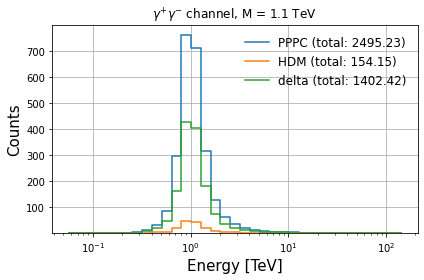

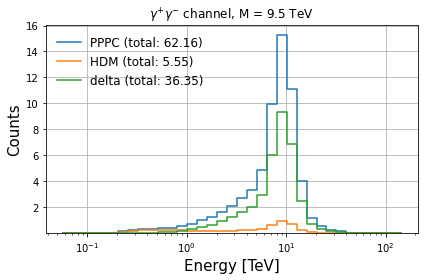

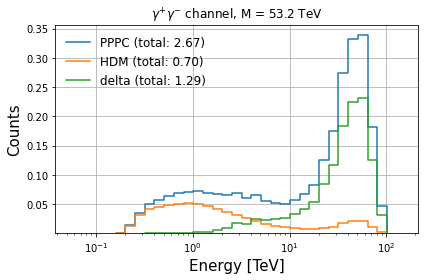

In [29]:
E = [const.mass4gamma_vegas[41], const.mass4gamma_vegas[60], const.mass4gamma_vegas[75]]
cnts = {}

chan = ["gamma"]
chan_lab = [r"$\gamma^{+}\gamma^{-}$"]
for c, cl in zip(chan, chan_lab):
    for en in E:
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        sig_vts_det = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="delta")
        x1, y1 = getArray(sig_vts)
        x2, y2 = getArray(sig_vts_hdm)
        x3, y3 = getArray(sig_vts_det)
        plt.step(x1/1e3, y1, label="PPPC (total: {:.2f})".format(sum(y1)), where="mid")
        plt.step(x2/1e3, y2, label="HDM (total: {:.2f})".format(sum(y2)), where="mid")
        plt.step(x3/1e3, y3, label="delta (total: {:.2f})".format(sum(y3)), where="mid")
        plt.xscale("log")
#        plt.yscale("log")
        plt.ylim(1e-3, )
        plt.title("{} channel, M = {:.1f} TeV".format(cl, en/1000))
        plt.grid()
        plt.legend(frameon=False, fontsize=12)
        plt.xlabel("Energy [TeV]", fontsize=15)
        plt.ylabel("Counts", fontsize=15)
        plt.tight_layout()
        plt.savefig("{}-{}.png".format(c, en))
        plt.show(block=False)

In [30]:
E = np.logspace(2.5, 8, 10)
dwarf = "ursa_minor"
cnts = {}
jProfile = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ"]
for c in chan:
    cnts[c] = []
    for en in tqdm(E):
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="PPPC", channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        cnts[c].append([sum(getArray(sig_vts)[1]), sum(getArray(sig_vts_hdm)[1]) ])
    cnts[c] = np.asarray(cnts[c])

[Warning] IRFs and package are mismatched. The package name is changed from EventDisplay to VEGAS.


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
gamma_mass = const.mass4gamma_vegas
cnt_delta = []
temp = []
for en in tqdm(gamma_mass):
    sig_pppc = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="gamma")
    sig_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="gamma")
    sig_delta = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="delta")
    temp.append([sum(getArray(sig_pppc)[1]), sum(getArray(sig_hdm)[1])])
    cnt_delta.append(sum(getArray(sig_delta)[1]))
cnt_delta = np.asarray(cnt_delta)
cnts["gamma"] = np.asarray(temp)

  0%|          | 0/162 [00:00<?, ?it/s]

In [32]:

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$"]

<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
<ipython-input-33-809f2fea4bc9>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], col

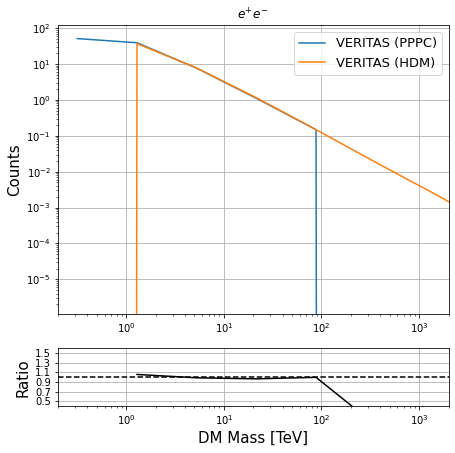

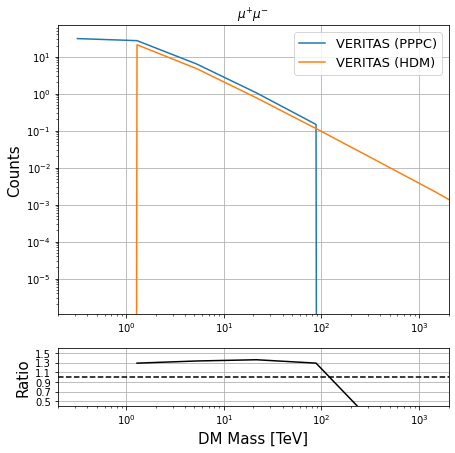

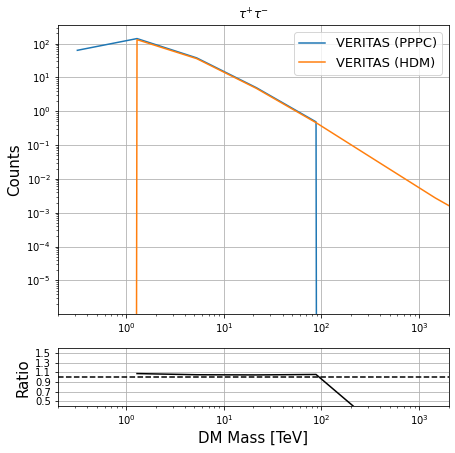

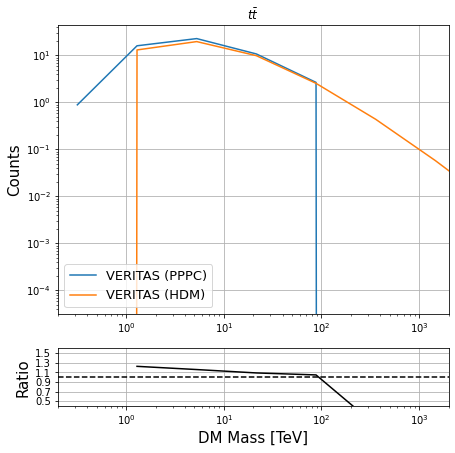

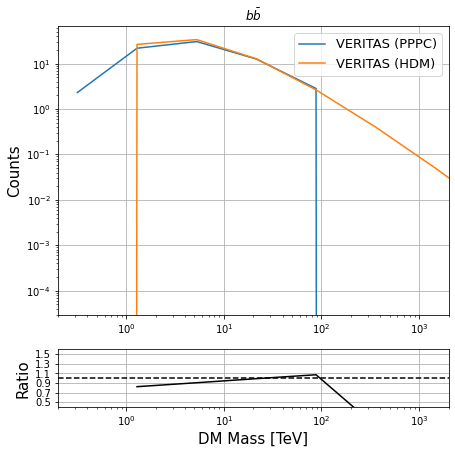

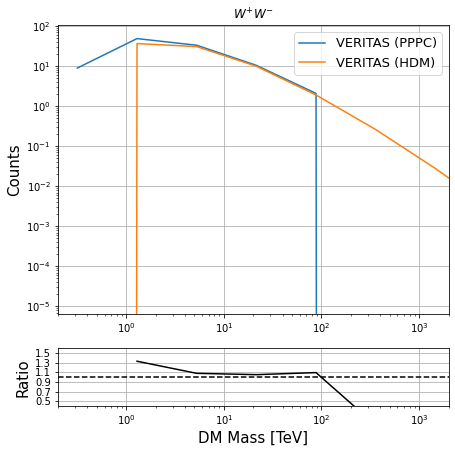

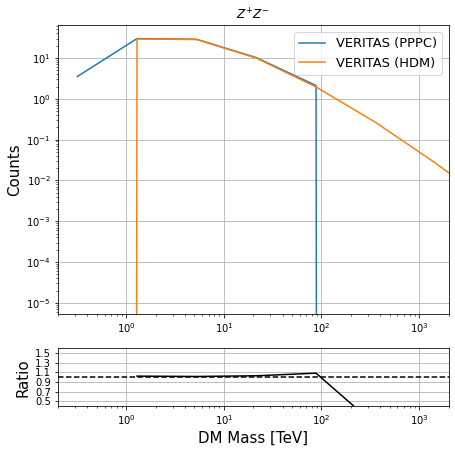

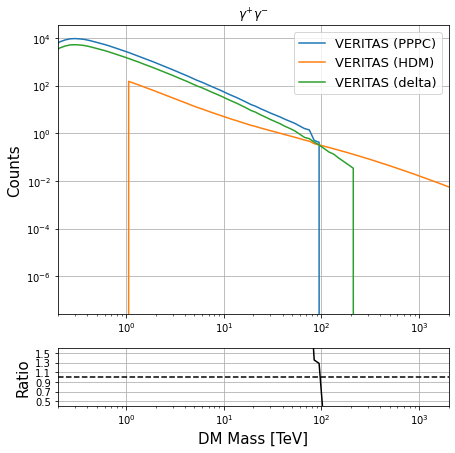

In [33]:
for c, cl in zip(chan, chan_lab):
    cnt = cnts[c]
    f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})

    if c == "gamma":
        etc = ax[0].plot(gamma_mass/1e3, cnt[:,0], label="VERITAS (PPPC)")
        etc2 = ax[0].plot(gamma_mass/1e3, cnt[:,1], label="VERITAS (HDM)")
        ax[0].plot(gamma_mass/1e3, cnt_delta, label="VERITAS (delta)")
        ax[1].plot(gamma_mass/1e3, cnt[:,0]/cnt[:,1], color="k")
    else:
        etc = ax[0].plot(E/1e3, cnt[:,0], label="VERITAS (PPPC)")
        etc2 = ax[0].plot(E/1e3, cnt[:,1], label="VERITAS (HDM)")
        ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].grid()
    ax[0].set_ylabel("Counts", fontsize=15)
    ax[0].legend(fontsize=13)
    ax[0].set_xlim(0.2, 2e3)
    ax[0].set_title(cl)
    
    ax[1].set_xscale("log")
    ax[1].set_xlabel("DM Mass [TeV]", fontsize=15)
    ax[1].set_ylim(0.4, 1.6)
    ax[1].set_yticks([0.5, 0.7, 0.9, 1.1, 1.3, 1.5])
    ax[1].axhline(1, color="k", ls="--")
    ax[1].grid()
    ax[1].set_ylabel("Ratio", fontsize=15)
    ax[1].set_xlim(0.2, 2e3)

## Step 8: Simulation study - significance plot

### Define ideal IRFs

In [37]:
dwarf = "segue_1"

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
irf.exposure = 50*3600
jProfile_vts = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)

[Warning] IRFs and package are mismatched. The package name is changed from EventDisplay to VEGAS.


  0%|          | 0/101 [00:00<?, ?it/s]

### Calculate total counts

In [38]:
M = np.load(SCRIPT_DIR+"/npy/mass4gamma_vegas.npy")

In [39]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$"]

M = np.logspace(4.3, 9, 7)

cnts = {}
for c in chan:
    cnts[c] = []
    if c == "gamma":
        M = np.load(SCRIPT_DIR+"/npy/mass4gamma_vegas.npy")
        M = M[(M>10**4.5)*(M<10**9)]
    for en in tqdm(M):
        sig_fake_hdm = 0
#        sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM", channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts, DM_spectra="HDM", channel=c)
        cnts[c].append([en, sum(getArray(sig_vts_hdm)[1])])
    cnts[c] = np.asarray(cnts[c])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Negative dN/dx values were set to 0 for the following x:
[0.99121115]
Caution around these values should be taken
A comparison with linear interpolation is recommended


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

### Plotting total count vs mass

In [199]:
for c, cl in zip(chan, chan_lab):
    M = cnts[c][:,0]
    cnt = cnts[c]
    f, ax = plt.subplots(1,1)
    etc = ax.plot(M/1e3, cnt[:,1], label="Realistic")
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,1]))
    etc = ax.plot(np.logspace(1.53, 5.9, 100), 10**f_mass(np.linspace(1.53, 5.9, 100)), label="fit", ls="--", color=etc[0].get_color())
                   
    etc2 = ax.plot(M/1e3, cnt[:,2], label="Ideal")
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,2]))
    etc = ax.plot(np.logspace(1.53, 5.9, 100), 10**f_mass(np.linspace(1.53, 5.9, 100)), label="fit", ls="--", color=etc2[0].get_color())

    
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()
    ax.set_ylabel("Counts", fontsize=15)
    ax.legend(fontsize=13)
    ax.set_xlim(20, 2e6)
    ax.set_title(cl)
    ax.set_xlabel("DM Mass [TeV]", fontsize=15)
    

NameError: name 'cnts' is not defined

### Significance plot for VERITAS

In [40]:
plt.style.use("default")

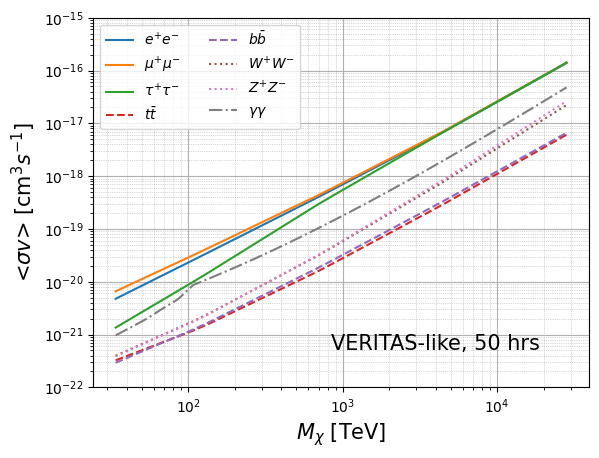

In [42]:
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_bkg = sum(events[:,2] == 0)
temp = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = temp.exposure/180000
N_bkg = N_bkg/t_ratio
#alpha = events[:,3][0]
alpha = 0.131

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]
mass = np.logspace(1.53, 4.45, 30)
sigma = np.logspace(-22, -15, 30)

for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,1]))
    five_sig = []
    for i, m in enumerate(mass):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+10**f_mass(np.log10(m))*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(mass, 10**five_sig,  label=cl, ls=l)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-22, 1e-15)
plt.grid()

plt.legend(ncol=2)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylabel(r"<$\sigma v$> [cm$^{3}s^{-1}$]", fontsize=15)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, r"$\mathcal{S}$ = 5$\sigma$", fontsize=15, ha="right", transform=ax.transAxes)

plt.grid(b=True, which="major")
plt.grid(b=True, which="minor", ls=":", lw=0.5)
    
plt.savefig("VERITAS_disc.pdf")

### Background fit

In [40]:
dwarf = "ursa_minor"
M =1000
package="VEGAS"
jSeed=defaultNum[dwarf]
mle_1d = Likelihood.MLE(dwarf, M, channel="tt",
                     package=package,
                     addTheta=False, 
                     averagedIRF=True,
                     ext=False,
                     useBias=True,
                     jArray=True,
                     jSeed=jSeed,
                     version="all",
                     bkgModel=None,
                     verbose=3) 

mle_1d.bkg_minuit(model="powerlaw")
logl_pl = mle_1d.bkg_logl
pars_pl = mle_1d.bkg_pars

mle_1d.bkg_minuit(model="bknpl")
logl_bknpl = mle_1d.bkg_logl
pars_bknpl = mle_1d.bkg_pars

mle_1d.bkg_minuit(model="powerlaw", fix_idx=True, index=-2.57)
logl_pl_fix = mle_1d.bkg_logl
pars_pl_fix = mle_1d.bkg_pars


print("BIC = {}".format(logl_pl-logl_bknpl-2*np.log(sum(mle_1d.args["hOff"] !=0)-1)))


[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] N = 1.253 +/- 0.022
[Log, Result] Index = -2.654 +/- 0.024
[Log, Result] N = 1.261 +/- 0.022
[Log, Result] Index = -2.678 +/- 0.029
[Log, Result] Eb = 14987.759 +/- 556.741
[Log, Result] Index2 = -2.335 +/- 0.186
[Log, Result] N = 1.207 +/- 0.017
[Log, Result] Index = -2.570 +/- 0.000
BIC = -4.0593009644927385


### Plot background fit 

Text(0, 0.5, 'Observed counts')

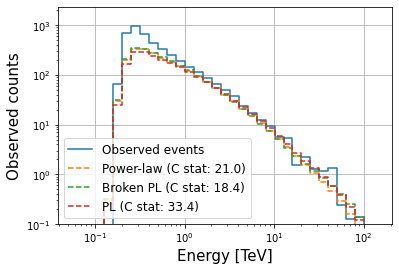

In [42]:
x, y = getArray(mle_1d.hOff)
plt.step(x/1e3, y, where="mid", label="Observed events")

bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="Power-law (C stat: {:.1f})".format(logl_pl))

bkg_fit = Likelihood.forwardFolding(utils.BKNPOWER, pars_bknpl, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="Broken PL (C stat: {:.1f})".format(logl_bknpl))

bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="PL (C stat: {:.1f})".format(logl_pl_fix))

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylim(1e-1)
plt.legend(fontsize=12)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Observed counts", fontsize=15)
#plt.text("BIC = {}".format(logl_pl-logl_bknpl-2*np.log(sum(mle_1d.args["hOff"] !=0)-1)))

### Get background counts for ideal IRFs

Text(0, 0.5, 'Observed counts')

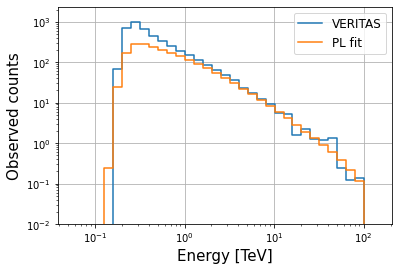

In [43]:
x, y = getArray(mle_1d.hOff)
plt.step(x/1e3, y, where="mid", label="VERITAS")

xi, yi = getArray(bkg_fit)
plt.step(xi/1e3, yi, where="mid", label="PL fit")

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylim(1e-2)
plt.legend(fontsize=12)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Observed counts", fontsize=15)

### Significance plot for ideal IRFs

In [197]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=newirf, alpha=1)
x, y = getArray(bkg_fit)
mass = np.logspace(1.53, 4.45, 30)
sigma = np.logspace(-23, -15, 30)
temp = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = temp.exposure/(50*3600)
N_bkg = sum(y) / t_ratio
alpha = events[:,3][0]


for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,2]))
    five_sig = []
    for i, m in enumerate(mass):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+10**f_mass(np.log10(m))*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(mass, 10**five_sig,  label=cl, ls=l)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-23, 1e-16)
plt.grid()

plt.legend(ncol=2)
plt.xlabel("DM mass [TeV]", fontsize=12)
plt.ylabel(r"<$\sigma\nu$> [cm$^{3}s^{-1}$]", fontsize=12)


NameError: name 'pars_pl_fix' is not defined

## Step 9: Expected upper limits

### VERITAS

In [59]:
dwarf = "segue_1"
mass = np.logspace(4.5, 7.5, 5)
package="VEGAS"
jSeed=defaultNum[dwarf]

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

jProfile_vts = JProfile.generateConvolvedJ(dwarf, seed=defaultNum[dwarf], return_array=True, save_root=False, package="VEGAS")

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
irf.exposure = 50*3600
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)

N_on_vts = sum(events[:,2] == 1)/t_ratio
N_off_vts = sum(events[:,2] == 0)/t_ratio

for channel in chan:
    filename = "veritas_{}".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, irf = irf, package=package, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, 
                                  useBias=True, verbosity=0, runs=10, filename=filename, multi=True,
                                  N_on=N_on_vts, N_off=N_off_vts)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).
[IPKernelApp] WARNING | WARNING: attempted to send message from fork
{'header': {'msg_id': '8b05b5a4-569a4c384faca9f01d091f53_3026', 'msg_type': 'comm_msg', 'username': 'dtak', 'session': '8b05b5a4-569a4c384faca9f01d091f53', 'date': datetime.datetime(2022, 3, 24, 17, 0, 48, 793551, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '8b05b5a4-569a4c384faca9f01d091f53_3026', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '920885ee3bff43e882350638db1e5d17', 'username': 'username', 'session': '1d024cf36220410c96dd8bd48b8680b8', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2022, 3, 24, 16, 55, 33, 963079, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 10/10 [01:36&lt;00:00,  4.70s/it]'}, 'buffer_paths': []}, 'comm_id': '39ead6fe343d4cf585992b6691e1cf38'}, 'metadata': {}}
[IPKernelApp] WARNING | WARNING: attempted to sen

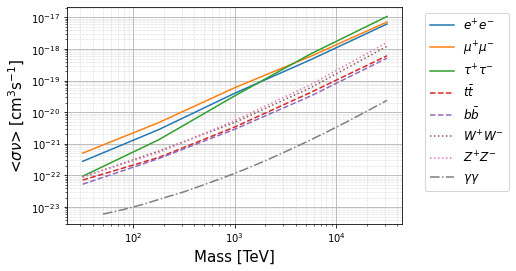

In [61]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "veritas_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)

### Ideal

In [43]:
from DarkMatter.Likelihood.simulation import gen_evt_1d

In [44]:
dwarf = "ursa_minor"

newirf = ResponseFunction.newirf("VEGAS")
gJProf = JProfile.calcJProfile(dwarf, seed=defaultNum[dwarf])
gPSF1D_fake = ResponseFunction.fakePSF(0.02)
J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
jProfile_fake = interp1d([10, 1e20], [J_fake, J_fake])
newirf.EA = ResponseFunction.fakeEA(1e6, benchmark="VEGAS", low_cutoff=0.4, s=1.2)
newirf.exposure = 50*3600
newirf.Bias = ResponseFunction.fakeBias(0.08, benchmark="VEGAS")

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
alpha = events[:,3][0]
bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=newirf, alpha=1)
x, y = getArray(bkg_fit)
N_temp = sum(getArray(bkg_fit)[1])
N_off_ideal = sum(y)/t_ratio
N_on_ideal = N_off_ideal*alpha
new_evts = gen_evt_1d(bkg_fit)
eventset = np.asarray([[evt[0], 0, 0, alpha] for evt in new_evts])
hOn, hOff = Likelihood.eventdisplay.readData(dwarf, events=eventset)

In [45]:
dwarf = "ursa_minor"
mass = np.logspace(4.5, 7.5, 5)
package="EventDisplay"
jSeed=defaultNum[dwarf]

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

for channel in chan:
    filename = "ideal_{}".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, irf = newirf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_fake, addTheta=False, version="all", ext=False, 
                                  useBias=True, verbosity=0, runs=10, filename=filename, multi=True, test=True,
                                  N_on=N_on_ideal, events=new_evts, alpha = alpha, hOff=hOff, N_off=N_off_ideal)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMET

[IPKernelApp] WARNING | WARNING: attempted to send message from fork
{'header': {'msg_id': '9940e0e8-0bcd46c50be7c97c0f3586bb_2378', 'msg_type': 'comm_msg', 'username': 'dtak', 'session': '9940e0e8-0bcd46c50be7c97c0f3586bb', 'date': datetime.datetime(2022, 3, 24, 21, 48, 36, 509442, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '9940e0e8-0bcd46c50be7c97c0f3586bb_2378', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'd1628594d6454ae48d35c4ce1b8b86e4', 'username': 'username', 'session': '1d024cf36220410c96dd8bd48b8680b8', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2022, 3, 24, 21, 48, 13, 51207, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 10/10 [00:17&lt;00:00,  1.08s/it]'}, 'buffer_paths': []}, 'comm_id': '823e18d211494be1b92c2da0af59590f'}, 'metadata': {}}
[IPKernelApp] WARNING | WARNING: attempted to send message from fork
{'header': {'msg_id': '9940e0e8-0bcd46c50be7c97c0f3586bb_2379',

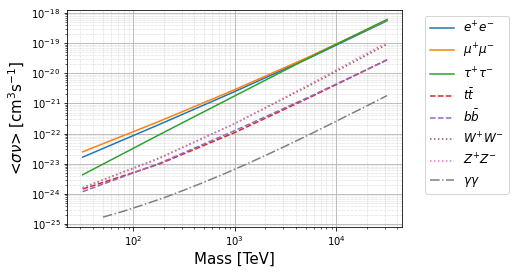

In [46]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "ideal_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)

## 10. Final results

### VERITAS-like

In [32]:
dwarf = "segue_1"

package="VEGAS"
jSeed=defaultNum[dwarf]

chan = ["gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS",  seed=defaultNum[dwarf], return_array=True, save_root=False)
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

irf.exposure = 50*3600
mass = np.logspace(4.5, 7.5, 5)


  0%|          | 0/101 [00:00<?, ?it/s]

In [28]:
dwarf = "segue_1"
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

irf.exposure = 50*3600
mass = np.logspace(4.5, 7.5, 5)


In [170]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
channel = "bbar"
for t in [48]:
    
    t_ratio = irf.exposure/(t*3600)    
    N_on_vts = sum(events[:,2]==1)/t_ratio
    N_off_vts = sum(events[:,2]==0)/t_ratio
    alpha = 0.131
    irf.exposure = t*3600
    mass = [1e5, 1e6, 1e7]
    filename = f"sanity_check_{t}"
    Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                      jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                      useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, statistic="simple",
                                      N_on=N_on_vts, alpha = alpha, N_off = N_off_vts)

  0%|          | 0/300 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minui

In [13]:
uls_t = {1e5: [], 1e6:[], 1e7:[]}
for t in [40,50, 80, 120, 200, 300, 400, 500]:

    filename = f"sanity_check_{t}"
    uls = np.load(const.OUTPUT_DIR+filename+".npy", allow_pickle=True).item()
    for m in uls.keys():
        uls_t[m].append([t, np.average(uls[m])])

for m in [1e5, 1e6, 1e7]:
    uls_t[m] = np.asarray(uls_t[m])

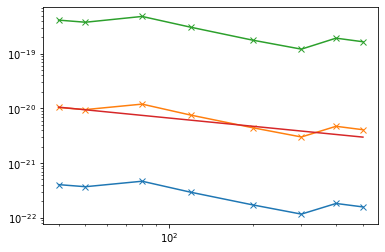

In [24]:
for m in [1e5, 1e6, 1e7]:
    plt.plot(uls_t[m][:,0], 10**uls_t[m][:,1], marker="x")
    
plt.plot(uls_t[m][:,0], 1/np.sqrt(uls_t[m][:,0])/1.5e19)
plt.xscale("log")
plt.yscale("log")

In [22]:

for channel in chan:
    if channel == "gamma":
        mass = np.logspace(4.5, 7.5, 5)
        mass = [1e5, 1.1e5]
    filename = "vts_like_{}_add".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, statistic="simple",
                                  N_on=N_on_vts, alpha = alpha, N_off = N_off_vts)

[Log] Package      : VEGAS
[Log] Dwarf        : segue_1
[Log] Channel      : gamma
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100000 GeV
[Log] Maximum mass : 110 TeV
[Log] Initialization (Done)                      


  0%|          | 0/200 [00:00<?, ?it/s]

[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.727) (equivalent to 1.88e-23)
[Log, Result] b = 65652 +/- 350 (null value: 65653)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.582) (equivalent to 2.62e-23)
[Log, Result] b = 65658 +/- 343 (null value: 65653)
[Log] Initializing... (VEGAS)
[Log] Step 1: Inst

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.827) (equivalent to 1.49e-23)
[Log, Result] b = 65562 +/- 338 (null value: 65562)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-23.143) (equivalent to 7.19e-24)
[Log, Result] b = 65463 +/- 359 (null value: 65476)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] S

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.765) (equivalent to 1.72e-23)
[Log, Result] b = 65641 +/- 342 (null value: 65639)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.628) (equivalent to 2.36e-23)
[Log, Result] b = 65639 +/- 345 (null value: 65639)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] S

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.641) (equivalent to 2.28e-23)
[Log, Result] b = 65631 +/- 345 (null value: 65631)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.869) (equivalent to 1.35e-23)
[Log, Result] b = 65595 +/- 344 (null value: 65601)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] S

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.806) (equivalent to 1.56e-23)
[Log, Result] b = 65621 +/- 344 (null value: 65621)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.673) (equivalent to 2.12e-23)
[Log, Result] b = 65620 +/- 339 (null value: 65621)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] S

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=100000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.561) (equivalent to 2.75e-23)
[Log, Result] b = 65659 +/- 369 (null value: 65713)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=110000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.424) (equivalent to 3.76e-23)
[Log, Result] b = 65659 +/- 368 (null value: 65713)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are 

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=110000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.527) (equivalent to 2.97e-23)
[Log, Result] b = 65666 +/- 320 (null value: 65672)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=100000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.685) (equivalent to 2.07e-23)
[Log, Result] b = 65658 +/- 385 (null value: 65666)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are 

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=100000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.577) (equivalent to 2.65e-23)
[Log, Result] b = 65660 +/- 379 (null value: 65706)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=110000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.437) (equivalent to 3.65e-23)
[Log, Result] b = 65658 +/- 378 (null value: 65706)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are 

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = 1.67 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.317) (equivalent to 4.82e-23)
[Log, Result] b = 65658 +/- 369 (null value: 65771)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] The signal (M=100000 GeV) is not significant (TS < 1).
[Log, Result] <σν> (95& upper limit) = 10^(-22.685) (equivalent to 2.06e-23)
[Log, Result] b = 65658 +/- 383 (null value: 65667)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loadin

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = 2.45 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.409) (equivalent to 3.90e-23)
[Log, Result] b = 65658 +/- 360 (null value: 65795)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = 2.45 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.273) (equivalent to 5.33e-23)
[Log, Result] b = 65659 +/- 370 (null value: 65795)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Ste

[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=110000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.605) (equivalent to 2.48e-23)
[Log, Result] b = 65649 +/- 335 (null value: 65647)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = -0.00 (M=100000 GeV)
[Log, Result] <σν> (95& upper limit) = 10^(-22.855) (equivalent to 1.40e-23)
[Log, Result] b = 65606 +/- 344 (null value: 65606)
[Log] Initializing... (VEGAS)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Loading events from inputs
[Log] S

Warning in <TROOT::Append>: Replacing existing TH1: hOn (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hOff (Potential memory leak).


In [30]:
irf.exposure/(48*3600)

1.0

In [41]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio =1
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
filename = "sanity_check_vts_bbar"
alpha = 0.131
channel = "bbar"
package="VEGAS"
jSeed = defaultNum[dwarf]
mass = np.logspace(3, 5, 5)

Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=True,
                              useBias=False, verbosity=0, runs=300, filename=filename, test=True, seed=8, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha,  N_off = N_off_vts)

  0%|          | 0/300 [00:00<?, ?it/s]

/Users/dtak/Software/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/dtak/Software/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minui

In [35]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = 1
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
filename = "sanity_check_vts_tt"
alpha = 0.131
channel = "tt"
package="VEGAS"
jSeed = defaultNum[dwarf]
mass = np.logspace(3, 5, 5)

Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=True,
                              useBias=False, verbosity=0, runs=300, filename=filename, test=True, seed=8, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha,  N_off = N_off_vts)

  0%|          | 0/300 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minui

In [224]:
a = np.load('/Users/dtak/Research/DarkMatter/Output/sanity_check_hawk.npy', allow_pickle=True).item()

b = {}
i=0
for k in a.keys():
    if i==0:
        b[k] = a[k]
        i=1
    else:
        i=0

b[100000.0] = a[100000.0]

a.keys()

np.save('/Users/dtak/Research/DarkMatter/Output/sanity_check_hawk_second.npy', b)

No handles with labels found to put in legend.


FileNotFoundError: [Errno 2] No such file or directory: 'segue_1_HAWC_bbar.npy'

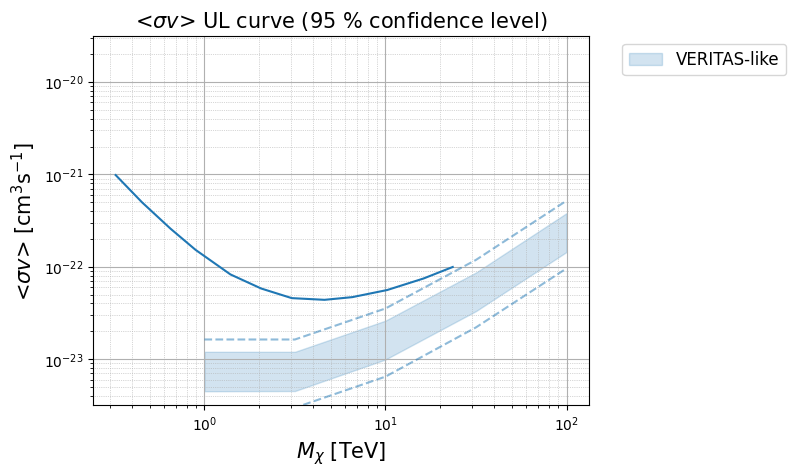

In [23]:
Likelihood.plotULcurve("VEGAS_segue_1_48h_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_bbar", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("segue_1_HAWC_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_bbar", label="HAWC-like", c=colors[1], units="TeV")
plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.savefig("sanity_check_bbar.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'HAWC_bbar.npy'

No handles with labels found to put in legend.


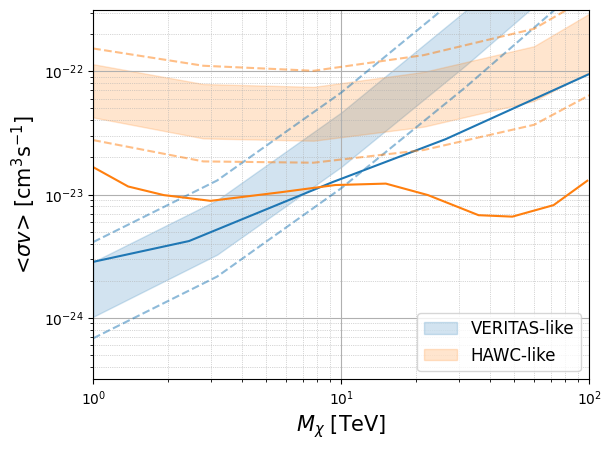

In [35]:
Likelihood.plotULcurve("veritas_216h_tt", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_tt", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("hawc_1038d_tt", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_second", label="HAWC-like", c=colors[1], units="TeV")
plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sanity_check.pdf")

No handles with labels found to put in legend.


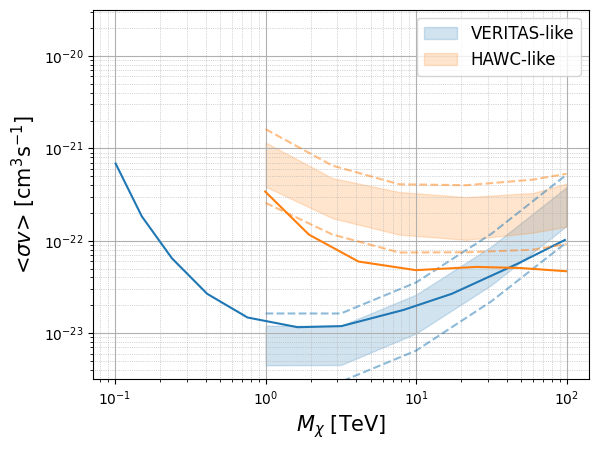

In [32]:
Likelihood.plotULcurve("veritas_216h_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_bbar", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("hawc_1038d_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_bbar_second", label="HAWC-like", c=colors[1], units="TeV")
#plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sanity_check.pdf")

In [39]:
plt.style.use("default")

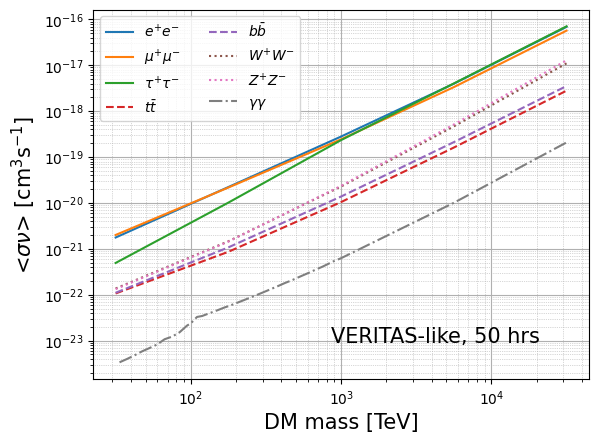

In [40]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "vts_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
plt.savefig("VERITAS_ULs.pdf")

In [49]:
mass = np.logspace(4.5, 7.5, 5)


In [80]:
print("a")

In [6]:
N_on_vts

8637.517698594074

In [7]:
N_off_vts

65658.17637309391

In [3]:
channel="ttbar"
package="VEGAS"
filename = "vts_like_{}_jsys".format(channel)
Likelihood.calcULSysError(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True,  addTheta=False, version="all", ext=False, multi=False,
                              useBias=True, verbosity=2, runs=1000, filename=filename, test=True, seed=9, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha, N_off = N_off_vts)

[Log] Package      : VEGAS
[Log] Dwarf        : segue_1
[Log] Channel      : ttbar
[Log] Dimention    : 1
[Log] Background   : None
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 31623 GeV
[Log] Maximum mass : 31623 TeV
[Log] Initialization (Done)                      


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/dtak/Research/scripts/dm-analysis/DarkMatter/JProfile/psf.py:46: RuntimeWarning: invalid value encountered in double_scalars
  psf_array.append([point[1], point[2]/norm*TMath.RadToDeg()**2.])


[Log] Upper-limit (including sys. error) calculation (Done)                                           
[Log] Upper-limits (including sys. error) are saved in '/Users/dtak/Research/DarkMatter/Output/vts_like_ttbar_jsys.npy'


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 0, 'DM mass [TeV]')

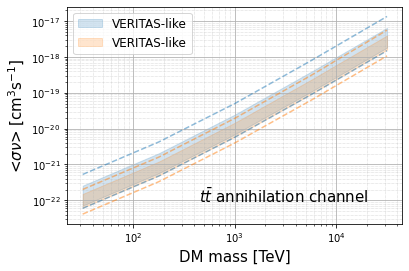

In [12]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="hawc_like_ttbar_jsys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

Text(0.5, 0, 'DM mass [TeV]')

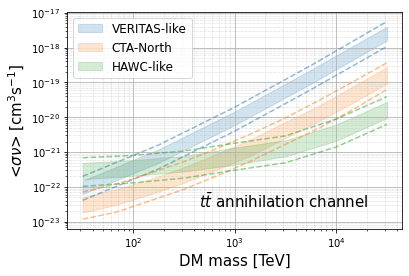

In [5]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

Text(0.5, 0, 'DM mass [TeV]')

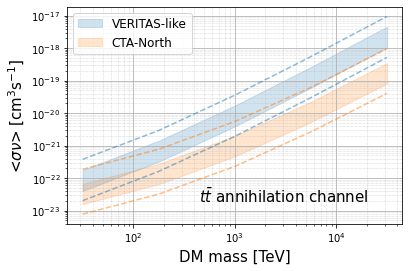

In [4]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

In [4]:
plt.style.use("default")

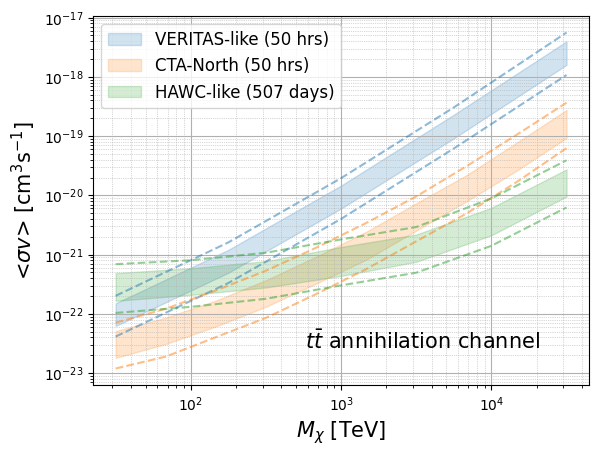

In [19]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like (507 days)", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("stat_err.pdf")

In [109]:
x = np.load(const.OUTPUT_DIR+"vts_like_ttbar_jsys.npy", allow_pickle=True).item()

In [110]:
y = []
for m in x.keys():
    y.append(np.percentile((10**np.asarray(x[m]))/10**np.average(x[m]), 84))
    y.append(1/np.percentile((10**np.asarray(x[m]))/10**np.average(x[m]), 16))

np.average(y)

2.096145735760762

1.0252308988983558

<ipython-input-53-f5d83119d3cb>:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10((10**np.asarray(x[m])-10**np.average(x[m]))/10**np.average(x[m])), bins=20)


(array([  1.,   0.,   0.,   0.,   1.,   3.,   7.,  12.,  35.,  39.,  78.,
        113., 102.,  60.,  21.,   1.,   5.,   0.,   0.,   1.]),
 array([-4.12492306, -3.78611479, -3.44730652, -3.10849825, -2.76968999,
        -2.43088172, -2.09207345, -1.75326518, -1.41445691, -1.07564865,
        -0.73684038, -0.39803211, -0.05922384,  0.27958443,  0.61839269,
         0.95720096,  1.29600923,  1.6348175 ,  1.97362577,  2.31243403,
         2.6512423 ]),
 <BarContainer object of 20 artists>)

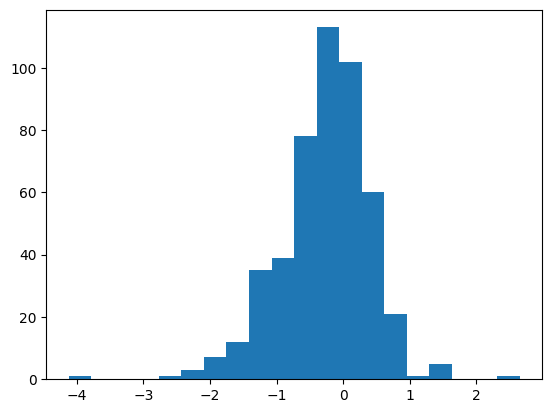

In [53]:
plt.hist(np.log10((10**np.asarray(x[m])-10**np.average(x[m]))/10**np.average(x[m])), bins=20)

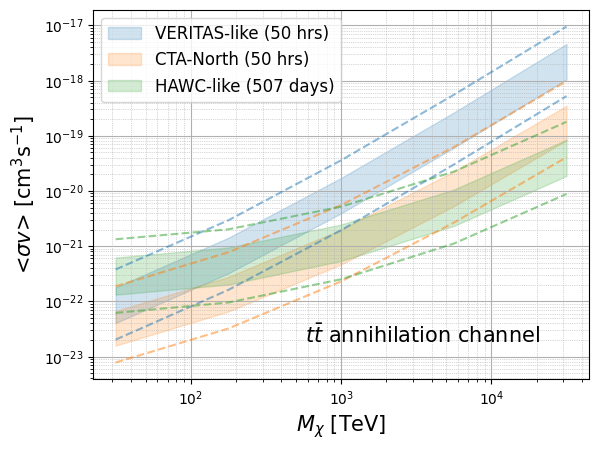

In [20]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_jsys", label="HAWC-like (507 days)", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sys_err.pdf")

In [4]:
vrel = 1.e-3
TeV2cm3s = 1.1673299710900705e-23

### s-wave Unitarity limit ###
# This is equation (10) of [Griest, Kamionkowski 1990], with J=0 for s-wave
def slim(m):
    "m [TeV]"
    return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)

# Add in the finite size, which is (5) in https://arxiv.org/pdf/2203.06029.pdf, or (16) in Kamionkowski and Griest (but they expand in the last step)

### Composite Unitarity limit ###
# This is equation (16) of [Griest, Kamionkowski 1990], but without the approximation that Jmax >> 1 as they use in the final step
def Rlim(m, Rinv):
    "m [TeV], Rinv [TeV]"
    R = 1./Rinv
    return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)*(1.+m*vrel*R)**2.

In [5]:
plt.style.use("default")

In [43]:

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True


In [1]:
#rescale=1.1
#plot_h = 10/rescale
#plot_w = 8/rescale
fig, ax = plt.subplots(1)

plt.xlabel(r'$M_{\chi}$ [TeV]',fontsize=28)
plt.ylabel(r'$\langle \sigma v \rangle$ [cm$^3$/s]',fontsize=28)

mpl.rcParams['lines.dashed_pattern'] = 7.5, 7.5
plt.axvline(340.,ls='--',c='gray',lw=1.)
plt.fill_between([340.,4.e4],[1.e-28,1.e-28],[1.e-16,1.e-16],color=(0.8,0.8,0.8),alpha=0.3)

plt.plot([10.,340.],[2.4e-26,2.4e-26],c='red',lw=2.)

mpl.rcParams['lines.dotted_pattern'] = 1.1, 2.5
mv=np.logspace(1.,np.log10(4.e4),100)
cv="black"
plt.plot(mv,Rlim(mv,1.e-3),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.e-2),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.e-1),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot([10.,4.e4],[slim(10.),slim(4.e4)],c='black',lw=2.,zorder=2)

plt.xscale('log')
plt.yscale('log')
plt.xlim([10.,4.e4])
#plt.ylim([1.e-28,1.e-17])

# Restore y ticks
locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0, 1.0, 11)[1:-1], numticks=1000)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Text
#plt.text(1.15e1,1.5e-18,r'Unitarity Limits',fontsize=13)

plt.text(2.5e2,6.e-27,r'Thermal $\langle \sigma v \rangle$',fontsize=13, ha="right")
plt.text(400,3.e-28,r'Non-Thermal Relic',fontsize=13,color=(0.3,0.3,0.3))
plt.text(1.1e3, 3e-26,r'Partial-Wave Unitarity',fontsize=13,color='black',rotation=340, ha="right")
plt.text(1.1e3,4e-20,r'Composite Unitarity',fontsize=13,color=cv, ha="right")

plt.text(3e4,3.5e-20,r'$R=(1~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-22,r'$R=(10~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-24,r'$R=(100~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-26,r'$R=(1~{\rm TeV})^{-1}$',fontsize=13,color=cv, ha="right")

#plt.tight_layout()
#plt.legend()
c = "ttbar"
filename = "vts_like_"+c
Likelihood.plotExpULcurve(filename=filename, label="VERITAS-like (50 hrs)", units="TeV",  mean_only=True)
filename = "cta_"+c
Likelihood.plotExpULcurve(filename=filename, label="CTA-North (50 hrs)", units="TeV", mean_only=True)
filename = "hawc_like_"+c
Likelihood.plotExpULcurve(filename=filename, label="HAWC-like (507 days)", units="TeV", mean_only=True)
#plt.xlabel(r'$M_{\chi}$ [TeV]',fontsize=15)
plt.xlim(25, )
plt.ylim(1e-28, 1e-16)
plt.legend(loc=2, fontsize=10)
plt.savefig('./HighMass-Limits.pdf')
plt.show()

NameError: name 'plt' is not defined

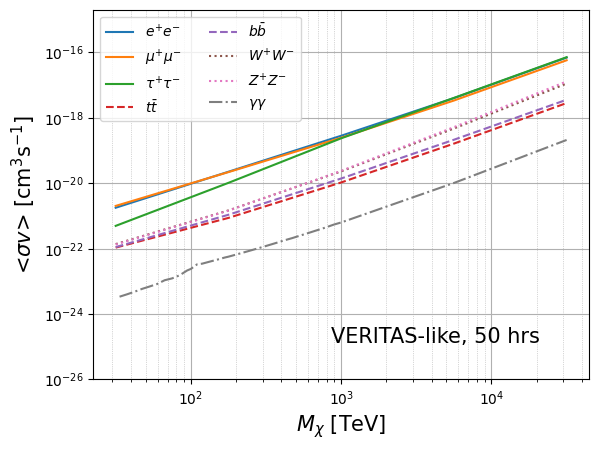

In [16]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "vts_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
plt.savefig("VERITAS_ULs.pdf")

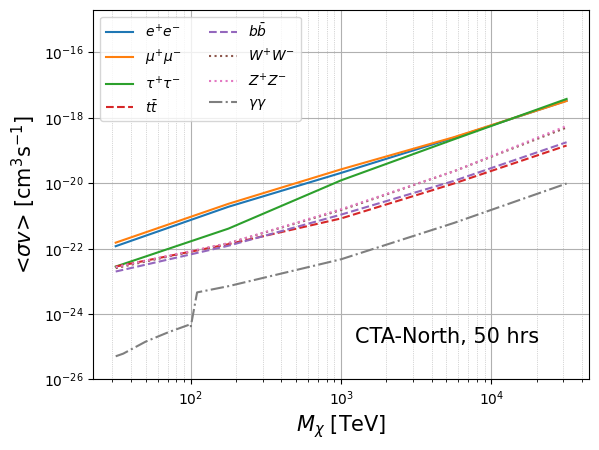

In [15]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "cta_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "CTA-North, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
plt.savefig("CTA_ULs.pdf")

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

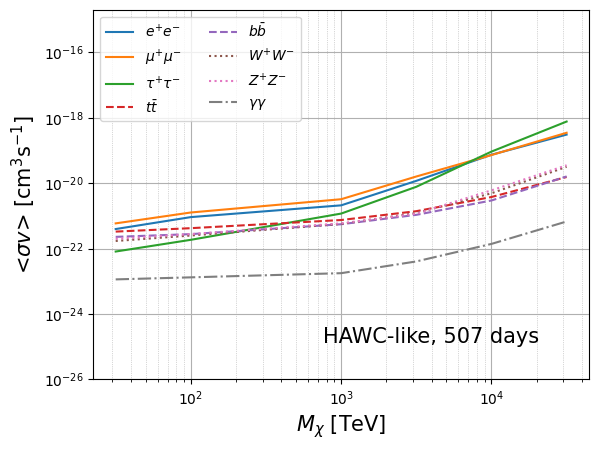

In [17]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "hawc_like_"+c+"_v2"
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "HAWC-like, 507 days", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
#plt.legend(fontsize=13, loc=2, ncol=2)
plt.savefig("HAWC_ULs.pdf")